In [1]:
import pandas as pd
from mlp_explainer.synthetic_data import SyntheticData

In [4]:
experiment_1 = SyntheticData('experiment_1')

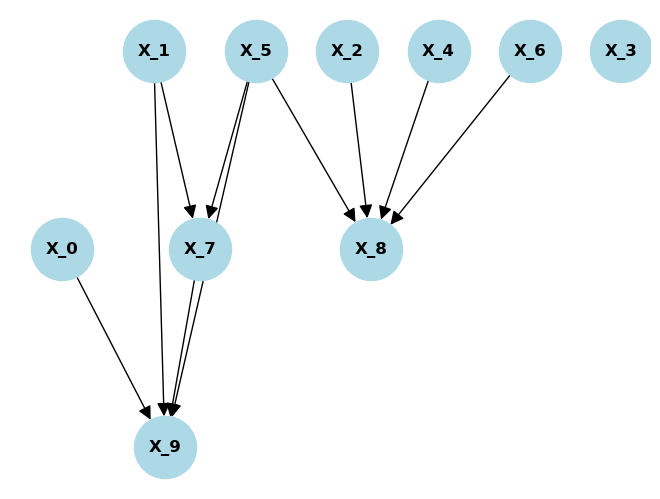

In [5]:
experiment_1.draw_network()

In [8]:
experiment_1.create_dataset()

In [10]:
experiment_1.save()

In [2]:
data = pd.read_csv('data/experiment_1_ground_data.csv')

In [3]:
data

,X_0,X_9,X_1,X_7,X_2,X_8,X_4,X_5,X_6,X_3
0,0.736171,1.349628,0.310295,-1.936901,-0.510876,0.073879,-1.372588,-1.207019,2.557790,1.867167
1,0.097620,1.550188,0.623697,1.677616,0.159525,0.829324,-0.284010,-1.612328,-4.903363,2.042087
2,-0.782206,1.366798,-0.580046,-1.644742,1.411088,-0.489850,-0.865691,0.422251,1.418502,-2.776573
3,0.837920,1.546008,0.365069,0.379893,-0.874937,-0.077551,0.466855,-0.646466,1.347210,3.300726
4,0.667889,1.534692,-1.077471,-0.065411,-0.796514,0.826219,0.246256,-2.136997,-0.126192,6.780782
...,...,...,...,...,...,...,...,...,...,...
4091,-1.709343,1.570069,-0.567511,-3.566038,1.765601,0.072953,-1.019434,-0.560844,3.539199,-2.310879
4092,-0.075945,1.350246,0.387054,-1.015197,0.091791,1.365334,-1.208456,-2.073965,-1.117212,3.549772
4093,0.731590,1.424048,-1.347156,-0.576713,-0.410887,0.743965,-1.118727,-2.183959,0.651947,4.862874
4094,1.876635,1.457447,-0.142572,-0.017105,-1.640007,1.118292,0.004579,-2.262159,1.444162,6.698131


In [4]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(data['X_0']))
data = data[z_scores < 3]

In [5]:
from sklearn.model_selection import train_test_split

X = data[["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7"]].values
y = data["X_9"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (3266, 8) (3266,)
Test shape: (817, 8) (817,)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Dense(32, activation = 'relu', input_shape=(X.shape[1],)),
    Dense(32, activation = 'sigmoid'),
    Dense(8, activation = 'relu'),
    Dense(1)  
])

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')

history = model.fit(X, y, epochs = 50, batch_size = 32, validation_split=0.2)

Epoch 1/50


/home/vmuser/miniconda3/envs/bayesnet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1495 - val_loss: 0.0196
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0135
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [14]:
loss = model.evaluate(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R² score: {r2:.4f}")
print(f"Final loss: {loss}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.0100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
R² score: 0.0120
Final loss: 0.010006444528698921
